In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score

In [4]:
from sklearn.ensemble import RandomForestRegressor

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [6]:
import joblib

In [7]:
import matplotlib.pyplot as plt

In [8]:
import seaborn as sns

In [9]:
df = pd.read_csv("data.csv")

In [10]:
df.rename(columns={
    "Wind Speed (m/s)": "Wind Speed",
    "Theoretical_Power_Curve (KWh)": "Theoretical Power",
    "Wind Direction (°)": "Wind Direction",
    "LV ActivePower (kW)": "Active Power"
}, inplace=True)

In [11]:
if 'Date/Time' in df.columns:
    df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%d %m %Y %H:%M', errors='coerce')

In [12]:
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

In [13]:
df_numeric = df[numeric_columns]

In [14]:
df.shape

(50530, 5)

In [15]:
df_numeric.describe()

,Active Power,Wind Speed,Theoretical Power,Wind Direction
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776282,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


In [16]:
missing_values = df_numeric.isnull().sum()

In [17]:
missing_percentage = (missing_values / len(df_numeric)) * 100

In [18]:
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage': missing_percentage
})

In [19]:
print(missing_df)

                   Missing Count  Percentage
Active Power                   0         0.0
Wind Speed                     0         0.0
Theoretical Power              0         0.0
Wind Direction                 0         0.0


In [20]:
correlation_matrix = df_numeric.corr()

In [21]:
target_correlations = correlation_matrix["Active Power"].sort_values(ascending=False)

In [22]:
target_correlations

Active Power         1.000000
Theoretical Power    0.949918
Wind Speed           0.912774
Wind Direction      -0.062702
Name: Active Power, dtype: float64

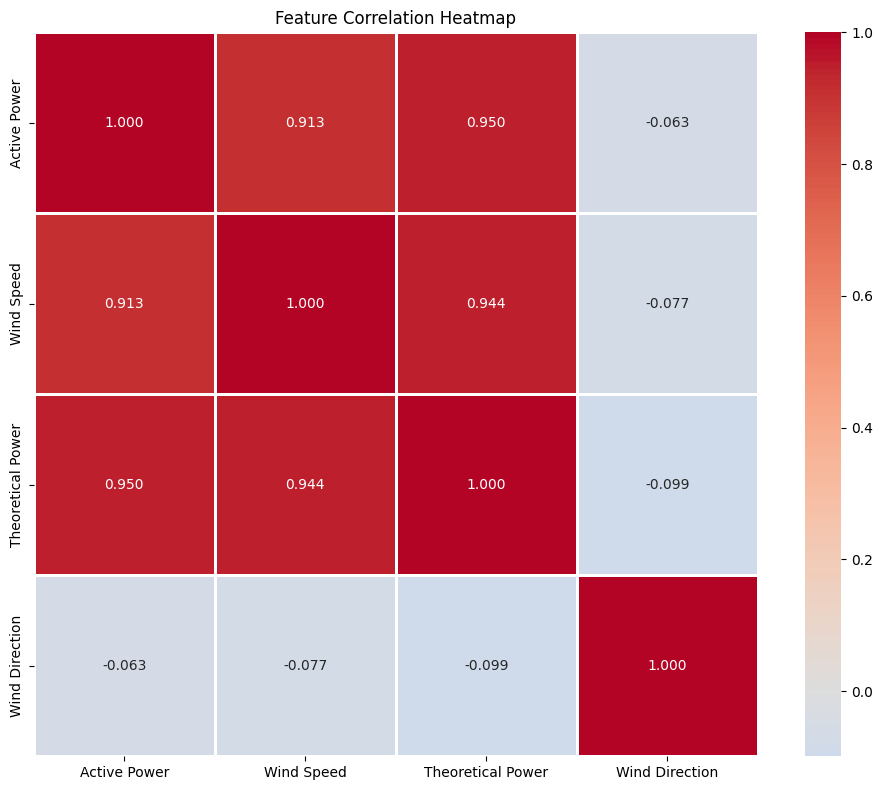

In [23]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.3f', square=True, linewidths=1)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

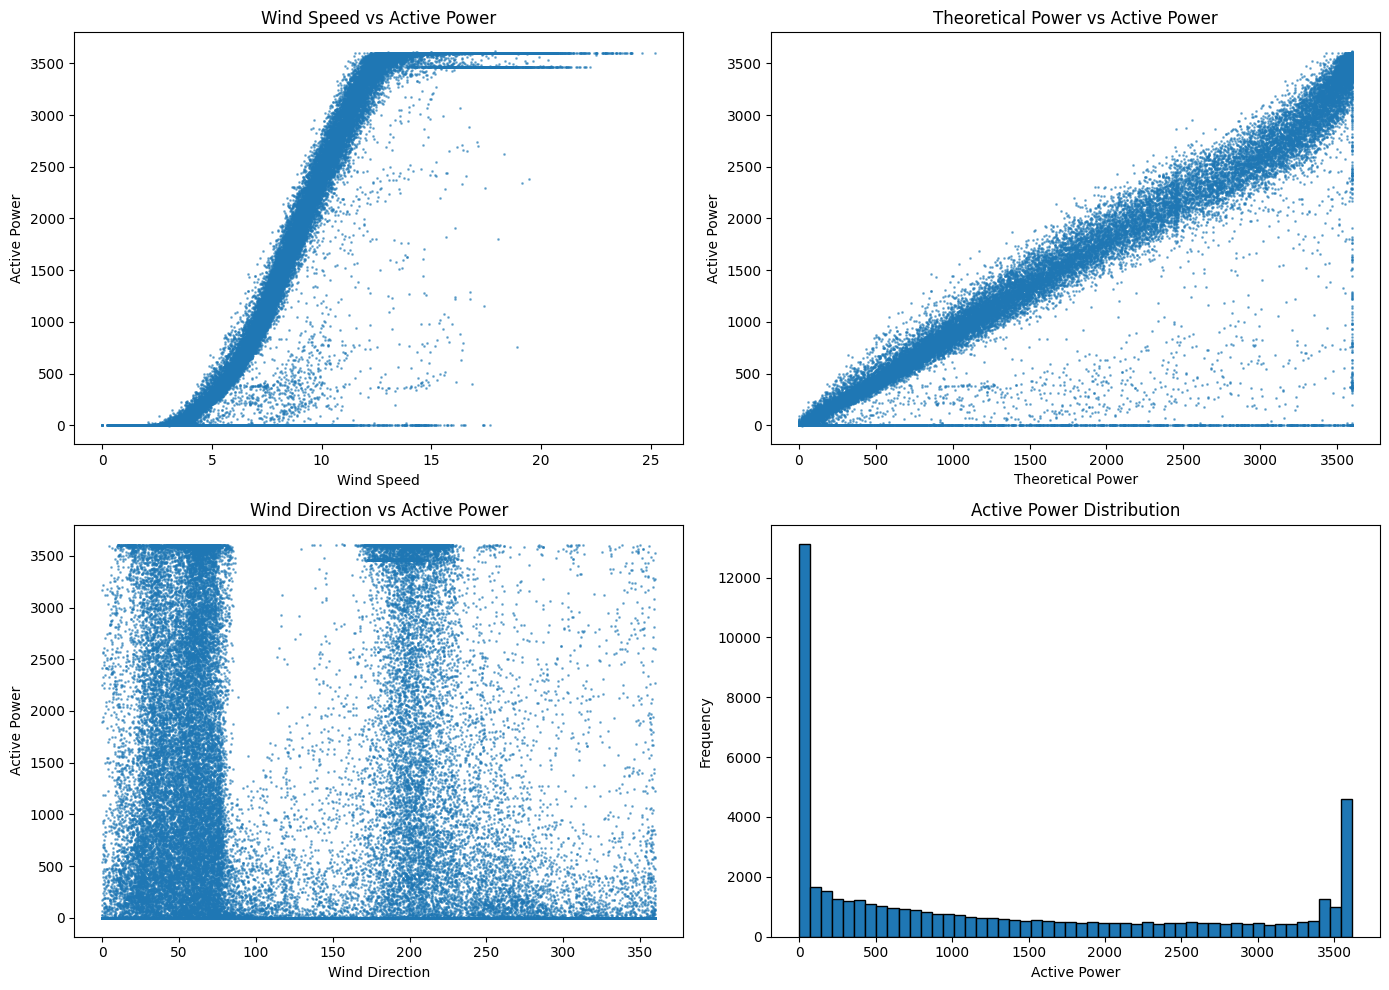

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].scatter(df_numeric["Wind Speed"], df_numeric["Active Power"], alpha=0.5, s=1)
axes[0, 0].set_xlabel('Wind Speed')
axes[0, 0].set_ylabel('Active Power')
axes[0, 0].set_title('Wind Speed vs Active Power')

axes[0, 1].scatter(df_numeric["Theoretical Power"], df_numeric["Active Power"], alpha=0.5, s=1)
axes[0, 1].set_xlabel('Theoretical Power')
axes[0, 1].set_ylabel('Active Power')
axes[0, 1].set_title('Theoretical Power vs Active Power')

axes[1, 0].scatter(df_numeric["Wind Direction"], df_numeric["Active Power"], alpha=0.5, s=1)
axes[1, 0].set_xlabel('Wind Direction')
axes[1, 0].set_ylabel('Active Power')
axes[1, 0].set_title('Wind Direction vs Active Power')

axes[1, 1].hist(df_numeric["Active Power"], bins=50, edgecolor='black')
axes[1, 1].set_xlabel('Active Power')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Active Power Distribution')

plt.tight_layout()
plt.show()

In [25]:
X = df[["Wind Speed", "Theoretical Power", "Wind Direction"]]

In [26]:
y = df["Active Power"]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [28]:
print(f"Training set size: {len(X_train)} ({len(X_train) / len(X) * 100:.1f}%)")

Training set size: 40424 (80.0%)


In [29]:
print(f"Test set size: {len(X_test)} ({len(X_test) / len(X) * 100:.1f}%)")

Test set size: 10106 (20.0%)


In [63]:
model = RandomForestRegressor(
    n_estimators=50,       
    max_depth=12,      
    min_samples_split=10,  
    min_samples_leaf=4,    
    max_features='sqrt',    
    n_jobs=-1,
    random_state=42
)

In [64]:
model.fit(X_train, y_train)

,n_estimators,50
,criterion,'squared_error'
,max_depth,12
,min_samples_split,10
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [65]:
cv_scores = cross_val_score(model, X_train, y_train, cv=5, 
                            scoring='r2', n_jobs=-1)

In [66]:
print(f"Mean CV R² score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

Mean CV R² score: 0.9160 (±0.0045)


In [67]:
y_train_pred = model.predict(X_train)

In [68]:
y_test_pred = model.predict(X_test)

In [69]:
train_mse = mean_squared_error(y_train, y_train_pred)

In [70]:
train_rmse = np.sqrt(train_mse)

In [71]:
train_mae = mean_absolute_error(y_train, y_train_pred)

In [72]:
train_r2 = r2_score(y_train, y_train_pred)

In [73]:
test_mse = mean_squared_error(y_test, y_test_pred)

In [74]:
test_rmse = np.sqrt(test_mse)

In [75]:
test_mae = mean_absolute_error(y_test, y_test_pred)

In [76]:
test_r2 = r2_score(y_test, y_test_pred)

In [77]:
print(f"Training - R²: {train_r2:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}")

Training - R²: 0.9367, RMSE: 330.4861, MAE: 135.9760


In [78]:
print(f"Test - R²: {test_r2:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}")

Test - R²: 0.9111, RMSE: 389.3888, MAE: 160.1058


In [79]:
overfitting_gap = train_r2 - test_r2

In [80]:
print(f"\nOverfitting gap: {overfitting_gap:.4f}")


Overfitting gap: 0.0256


In [81]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

In [82]:
feature_importance

,Feature,Importance
1,Theoretical Power,0.518100
0,Wind Speed,0.433045
2,Wind Direction,0.048855


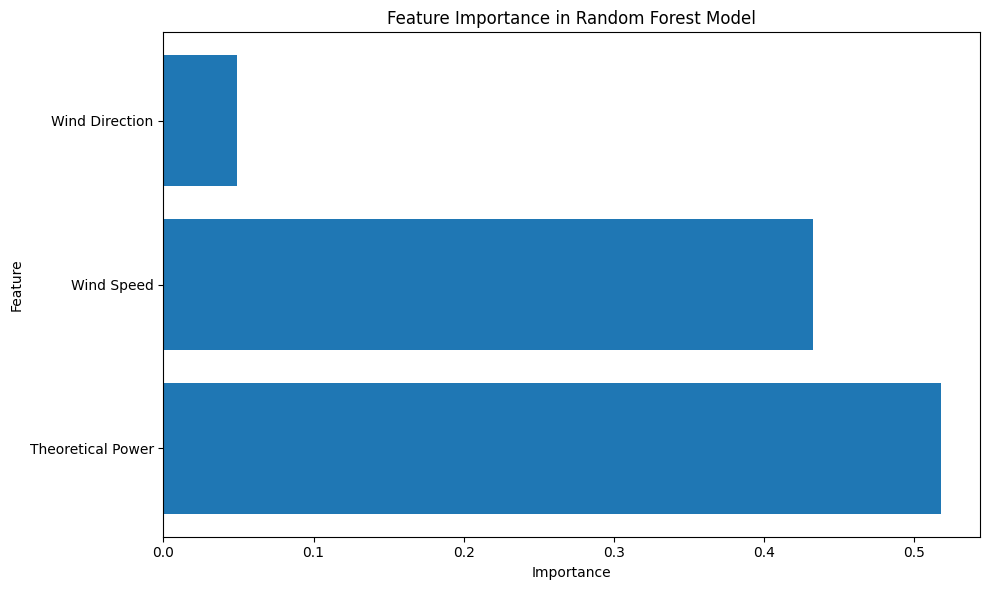

In [83]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model')
plt.tight_layout()
plt.show()

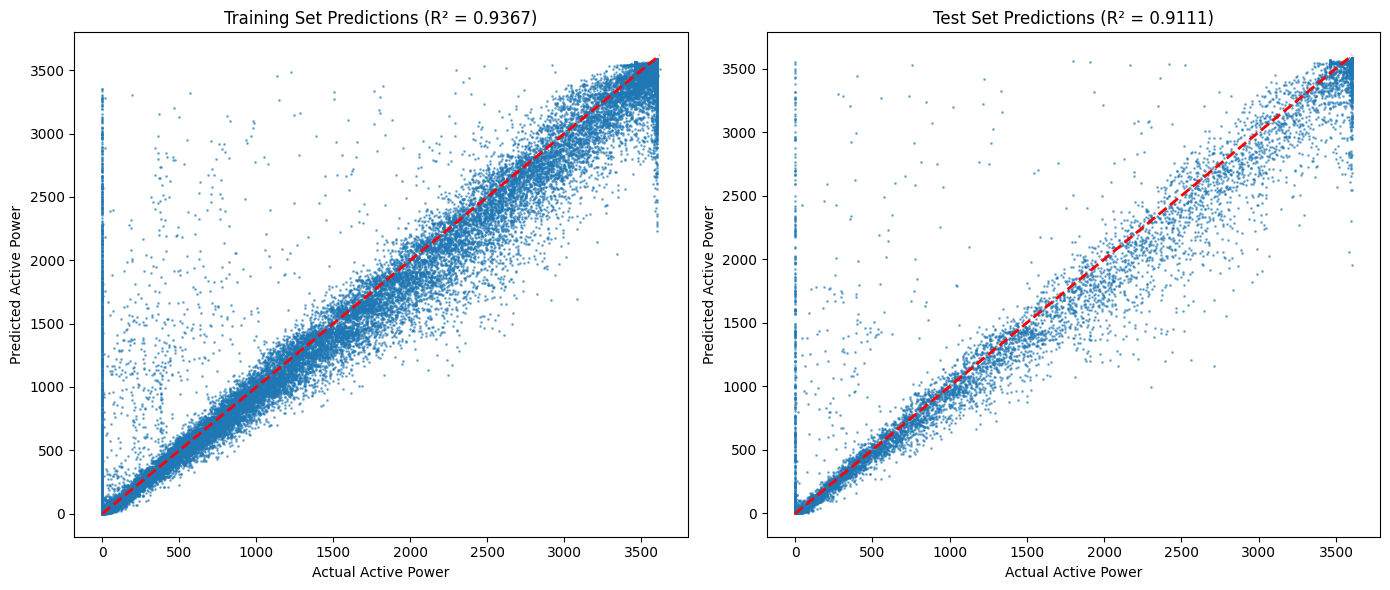

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(y_train, y_train_pred, alpha=0.5, s=1)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
             'r--', lw=2)
axes[0].set_xlabel('Actual Active Power')
axes[0].set_ylabel('Predicted Active Power')
axes[0].set_title(f'Training Set Predictions (R² = {train_r2:.4f})')

axes[1].scatter(y_test, y_test_pred, alpha=0.5, s=1)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2)
axes[1].set_xlabel('Actual Active Power')
axes[1].set_ylabel('Predicted Active Power')
axes[1].set_title(f'Test Set Predictions (R² = {test_r2:.4f})')

plt.tight_layout()
plt.show()

In [85]:
train_residuals = y_train - y_train_pred

In [86]:
test_residuals = y_test - y_test_pred

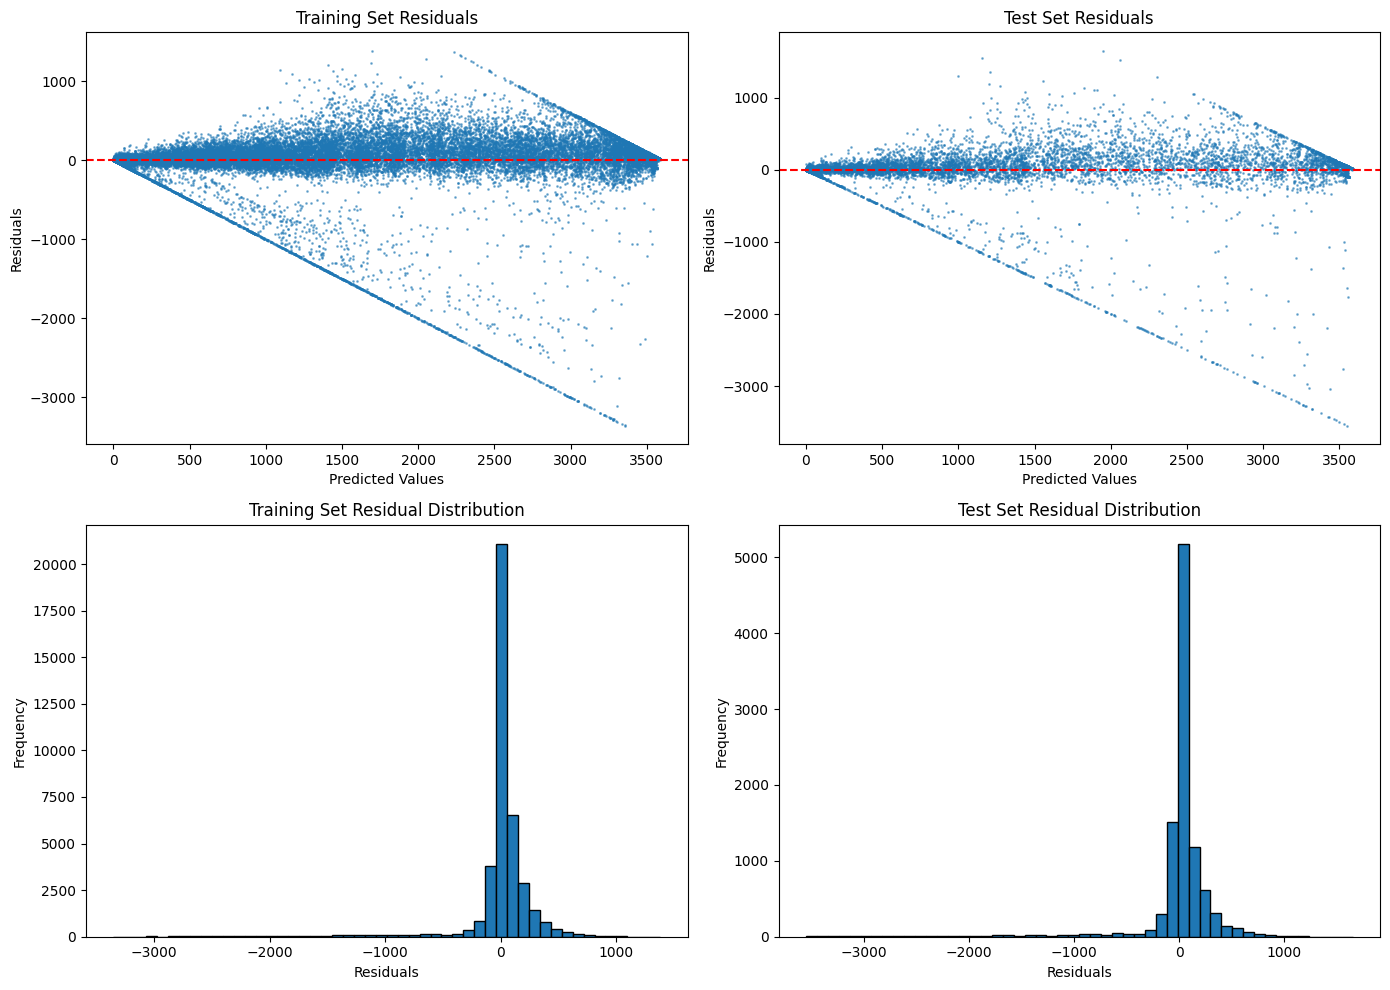

In [87]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].scatter(y_train_pred, train_residuals, alpha=0.5, s=1)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Predicted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Training Set Residuals')

axes[0, 1].scatter(y_test_pred, test_residuals, alpha=0.5, s=1)
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Predicted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Test Set Residuals')

axes[1, 0].hist(train_residuals, bins=50, edgecolor='black')
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Training Set Residual Distribution')

axes[1, 1].hist(test_residuals, bins=50, edgecolor='black')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Test Set Residual Distribution')

plt.tight_layout()
plt.show()

In [88]:
print(f"Training residuals mean: {train_residuals.mean():.4f}")

Training residuals mean: 0.0715


In [89]:
print(f"Training residuals std: {train_residuals.std():.4f}")

Training residuals std: 330.4902


In [90]:
print(f"Test residuals mean: {test_residuals.mean():.4f}")

Test residuals mean: -3.9405


In [91]:
print(f"Test residuals std: {test_residuals.std():.4f}")

Test residuals std: 389.3881


In [92]:
joblib.dump(model, "model.pkl", compress=3)

['model.pkl']

In [60]:
print("Model saved as model.pkl")

Model saved as model.pkl


In [93]:
model_metadata = {
    'features': list(X.columns),
    'train_size': len(X_train),
    'test_size': len(X_test),
    'train_r2': train_r2,
    'test_r2': test_r2,
    'train_rmse': train_rmse,
    'test_rmse': test_rmse,
    'feature_importance': feature_importance.to_dict('records')
}

In [94]:
joblib.dump(model_metadata, "model_metadata.pkl")

['model_metadata.pkl']

In [95]:
print("Model metadata saved as model_metadata.pkl")

Model metadata saved as model_metadata.pkl
